# Notebook for evaluating if residuals are Gaussian

In [ ]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import pandas as pd
from tqdm import tqdm
from utils import generate_population, CDF_model, get_ate, estimate_ate_with_pred_dists, calculate_errors

RANDOM_STATE = 42
sigma_X = 5.0
n_train_samples = 60000
n_trial_samples = 10000
tau = 0.2

def img_proxy_func(Y):
    return np.vstack([2 * Y, 3 * Y, -4 * Y]).T

def fit_and_calibrate_model(X_train: np.ndarray, Y_train: np.ndarray, seed: int = 42) -> CDF_model:
    """
    Fits and calibrates the CDF_model on training data.

    Parameters:
    X_train (np.ndarray): Training data features.
    Y_train (np.ndarray): Training data labels.
    seed (int): Random seed for reproducibility (default: 42).

    Returns:
    CDF_model: The fitted and calibrated CDF_model.
    """
    X_train, X_cal, Y_train, Y_cal = train_test_split(X_train, Y_train, test_size=0.25, random_state=seed)
    model = CDF_model()
    model.fit(X_train, Y_train)
    model.calibrate(X_cal, Y_cal)
    return model

In [ ]:
train_pop = generate_population(img_proxy_func, tau=tau, n_samples=n_train_samples, sigma_X=sigma_X, seed=RANDOM_STATE)
trial_pop = generate_population(img_proxy_func, tau=tau, n_samples=n_trial_samples, sigma_X=sigma_X, seed=RANDOM_STATE + 1)
X_train = np.vstack(train_pop['X'].values)
Y_train = train_pop['Y'].values
X_trial = np.vstack(trial_pop['X'].values)
A_trial = trial_pop['A'].values
p_A_trial = trial_pop['p_A_given_C'].values
Y_trial = trial_pop['Y'].values

sample_tau = get_ate(A_trial, Y_trial, p_A_trial)
print("Estimated true ATE (using true labels) of trial data:", sample_tau)

Estimated true ATE (using true labels) of trial data: 0.18156774663204314


In [ ]:
model = fit_and_calibrate_model(X_train, Y_train, seed=RANDOM_STATE)
y_hat_trial = model.biased_model.predict(X_trial)
y_tilde_trial = (y_hat_trial - model.m) / model.k
r2_score = 1 - np.sum((Y_trial - y_tilde_trial) ** 2) / np.sum((Y_trial - np.mean(Y_trial)) ** 2)
print("R^2 score on trial set:", r2_score)

R^2 score on trial set: 0.5939968567845002


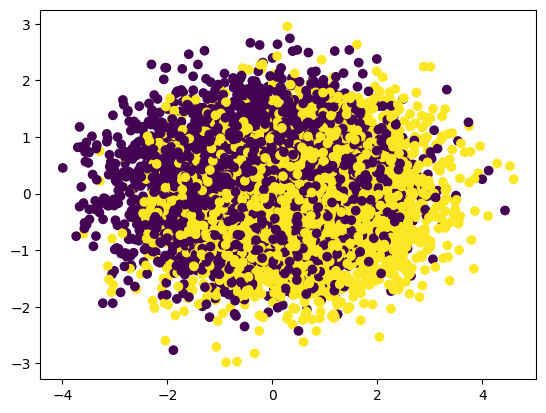

In [ ]:
import matplotlib.pyplot as plt

e_1 = y_hat_trial-Y_trial

plt.scatter(y_hat_trial, e_1, c=A_trial)

In [ ]:
print(f'Residual distribution: N({e_1.mean():.2f}, {e_1.var():.2f})')
print('Covariance between Y_hat and e_1:', np.cov(y_hat_trial, e_1)[0, 1])

Residual distribution: N(0.01, 0.62)
Covariance between Y_hat and e_1: -0.005237401937270145


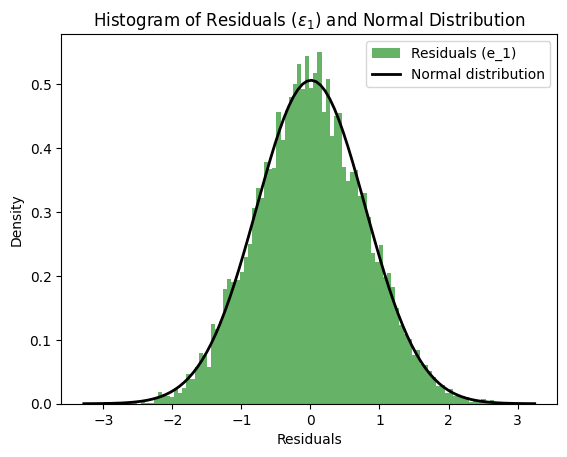

In [ ]:
from scipy.stats import norm, kstest

# Plot histogram of e_1
plt.hist(e_1, bins=100, density=True, alpha=0.6, color='g', label='Residuals (e_1)')

# Plot normal distribution for comparison
mu, std = norm.fit(e_1)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2, label='Normal distribution')

# Add legend and titles
plt.legend(loc='upper right')
plt.title(r'Histogram of Residuals ($\epsilon_1$) and Normal Distribution')
plt.xlabel('Residuals')
plt.ylabel('Density')

plt.show()

In [ ]:
np.mean(e_1 ** 2)

0.6210662142553538